In [1]:
from pathlib import Path

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/gdrive')
    print('-------')
    %cd /gdrive/MyDrive/compVision-DCC/t1/
    print('-------')
elif Path.cwd().parent.stem == 't1':
    print('-------')
    %cd ..
    print('-------')

-------
/home/step/Personal/UCH/2021-sem1/VisionComp/t1
-------


In [2]:
import train
from train import *
from dataset import ClothingSmall, parse_function, train_preprocess
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
print(train.__doc__)


jsaavedr, 2020
This allows you to train and test your model

Before using this program, set the path where the folder "covnet2"  is stored.
To use train.py, you will require to send the following parameters :
 * -config : A configuration file where a set of parameters for data construction and trainig is set.
 * -name: A section name in the configuration file.
 * -mode: [train, test] for training, testing, or showing  variables of the current model. By default this is set to 'train'
 * -save: Set true for saving the model


 Extension made by Victor Faraggi, 2021

 Added modularity. Now you can import the following functions:
    - create_config(name, config_file=None, config_str=None)
        -> return a ConfigurationFile from config_file path or config_str
    - parse_config(config)
        -> returns dict w/ tfr_files
    - load_dataset(config, tfr_train_file, tfr_test_file)
        -> returns a dict w/ train/test datasets, mean_image, input_shape and number_of_classes
    - create

# ResNet-50


In [4]:
resnet50_config = \
"""[FASHION-RESNET50]
# Training Related
NUM_EPOCHS = 16
NUM_CLASSES = 19
BATCH_SIZE = 128
SNAPSHOT_STEPS = 500
VALIDATION_STEPS = 100
LEARNING_RATE = 0.003
USE_L2 = True
WEIGHT_DECAY = 1e-4

SNAPSHOT_DIR = snapshots/snapshots-r50/

# Dataset Related
DATA_DIR = data/clothing-small/
SHUFFLE_SIZE = 10000
CHANNELS = 3
IMAGE_TYPE = IMAGE
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

#for tf_records to use multithreads
USE_MULTITHREADS = True
NUM_THREADS = 10

#CKPFILE is used for fine tunning
#CKPFILE =/home/step/Personal/UCH/2021-sem1/VisionComp/t1/chks
"""

with open("configs/t1_resnet50.config", 'w') as conf:
    conf.write(resnet50_config)

## Configuration and Dataset

In [5]:
model_name = 'resnet-50'

config = create_config("FASHION-RESNET50", "configs/t1_resnet50.config")
tfr_files = parse_config(config, mode='train')
datasets = load_dataset(config, tfr_files['train'], tfr_files['test'], 'train')

In [6]:
from dataset import ClothingSmall

process_func = lambda img, label : train_preprocess(img, label, seed=[8, 8])

csDataset = ClothingSmall(data_dir = config.get_data_dir())

csDataset.prepare()

csDataset.make_ds(parse_function, process_func)


# datasets = {
#     'train' : csDataset.train_ds,
#     'test' : csDataset.test_ds
# }


## Create Callbacks

In [7]:
tb_cb, chk_cb = create_cbs(config)

### LRFinder

In [8]:
from custom import determine_learning_rate

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6
Model is Resnet-50
(224, 224, 3)
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23546048  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,584,979
Trainable params: 23,539,411
Non-trainable params: 45,568
_________________________________________________________________
Epoch 1/5
250/250 [==============================] - 53s 167ms/step - loss: 8.2604 - accuracy: 0.0

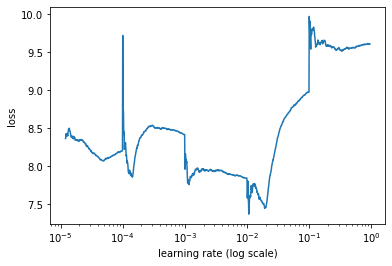

In [9]:
model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
determine_learning_rate(model, datasets['train'], tf.keras.optimizers.SGD(), config.get_batch_size())

Model is Resnet-50
(224, 224, 3)
Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23546048  
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,584,979
Trainable params: 23,539,411
Non-trainable params: 45,568
_________________________________________________________________
Epoch 1/5
250/250 [==============================] - 51s 167ms/step - loss: 8.1546 - accuracy: 0.0554
Epoch 2/5
250/250 [==============================] - 47s 166ms/step - loss: 8.0571 - accuracy: 0.0631
Epoch 3/5
250/250 [==============================] - 47s 168ms/step - loss: 8.0540 - accuracy: 0.0617
Epoch 4/5
250/250 [============

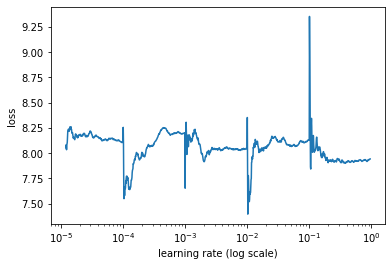

In [10]:
model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
determine_learning_rate(model, datasets['train'], tf.keras.optimizers.Adam(), config.get_batch_size())

Model is Resnet-50
(224, 224, 3)
Model: "res_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23546048  
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,584,979
Trainable params: 23,539,411
Non-trainable params: 45,568
_________________________________________________________________
Epoch 1/5
250/250 [==============================] - 56s 176ms/step - loss: 7.8734 - accuracy: 0.0585
Epoch 2/5
250/250 [==============================] - 49s 175ms/step - loss: 8.1866 - accuracy: 0.0614
Epoch 3/5
250/250 [==============================] - 49s 175ms/step - loss: 7.6331 - accuracy: 0.0655
Epoch 4/5
250/250 [============

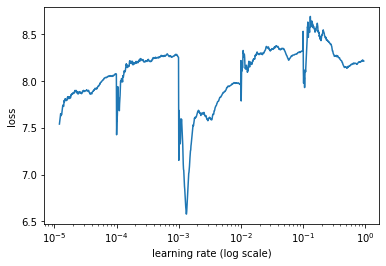

In [11]:
model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
determine_learning_rate(model, datasets['train'], tf.keras.optimizers.Nadam(), config.get_batch_size())

## Optimizer

In [9]:
cosine_sched = create_scheduler(config)
opt = create_opt('adam', config)

## Model

In [10]:
model = create_model(config, 'resnet-50', csDataset.input_shape, use_mixed=True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6
Model is Resnet-50
(224, 224, 3)
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23546048  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,584,979
Trainable params: 23,539,411
Non-trainable params: 45,568
_________________________________________________________________


## Run

In [11]:
datasets['train'] = datasets['train'].prefetch(1)
datasets['test'] = datasets['test'].prefetch(1)

In [12]:
history = run_model('train', model, opt, datasets, config, [chk_cb], [tb_cb])

AttributeError: module 'tensorflow.keras' has no attribute 'CategoricalCrossentropy'

## Run TFRecords Dataset w/ custom scheduler

In [10]:
sched = create_scheduler(config, 'cyclic', {'base_lr': 1e-3, 'max_lr': 8e-3})
opt = create_opt('adam', config)

In [11]:
datasets['train'] = datasets['train'].prefetch(1)
datasets['test'] = datasets['test'].prefetch(1)
model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
history = run_model('train', model, opt, datasets, config, [chk_cb, sched], [tb_cb])

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6
Model is Resnet-50
(224, 224, 3)
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23546048  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,584,979
Trainable params: 23,539,411
Non-trainable params: 45,568
_________________________________________________________________
Epoch 1/16
250/250 [==============================] - 41s 114ms/step - loss: 2.5788 - categorical_

In [10]:
from sklearn.metrics import confusion_matrix

acc_dict = dict()
acc_per_class_dict = dict()

with tf.device('/gpu:0'):
    model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
    model.load_weights('snapshots/snapshots-r50/016.h5')
    
    accs = []
    accs_per_class = []
    for x, y in datasets['test']:
        preds = model.predict(x)
        acc = (tf.math.argmax(preds, 1) == tf.math.argmax(y, 1)).numpy().sum() / len(y)
        
        matrix = confusion_matrix(tf.math.argmax(preds, 1), tf.math.argmax(y, 1))
        acc_per_class = matrix.diagonal()/matrix.sum(axis=1)
        
        accs.append(acc); accs_per_class.append(acc_per_class)
        
    accs = np.array(accs).mean()
    accs_per_class = np.array(accs_per_class).mean(0)
    
np.save('snapshots/snapshots-r50/acc.npy', accs)
np.save('snapshots/snapshots-r50/acc_classes.npy', accs_per_class)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6
Model is Resnet-50
(224, 224, 3)
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23546048  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,584,979
Trainable params: 23,539,411
Non-trainable params: 45,568
_________________________________________________________________


In [11]:
from sklearn.metrics import confusion_matrix

acc_dict = dict()
acc_per_class_dict = dict()

with tf.device('/gpu:0'):
    model = create_model(config, 'resnext', csDataset.input_shape, use_mixed=True)
    model.load_weights('snapshots/snapshots-resnext/016.h5')
    
    accs = []
    accs_per_class = []
    for x, y in datasets['test']:
        preds = model.predict(x)
        acc = (tf.math.argmax(preds, 1) == tf.math.argmax(y, 1)).numpy().sum() / len(y)
        
        matrix = confusion_matrix(tf.math.argmax(preds, 1), tf.math.argmax(y, 1))
        acc_per_class = matrix.diagonal()/(matrix.sum(axis=1) + 1e-8)
        
        accs.append(acc); accs_per_class.append(acc_per_class)
        
    accs = np.array(accs).mean()
    accs_per_class = np.array(accs_per_class).mean(0)
    
np.save('snapshots/snapshots-resnext/acc.npy', accs)
np.save('snapshots/snapshots-resnext/acc_classes.npy', accs_per_class)

Model is Resnext-50
(224, 224, 3)
Model: "res_next"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23033024  
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,071,955
Trainable params: 23,011,283
Non-trainable params: 60,672
_________________________________________________________________


In [12]:
from sklearn.metrics import confusion_matrix

acc_dict = dict()
acc_per_class_dict = dict()

with tf.device('/gpu:0'):
    model = create_model(config, 'alexnet', csDataset.input_shape, use_mixed=True)
    model.load_weights('snapshots/snapshots-alexnet/016.h5')
    
    accs = []
    accs_per_class = []
    for x, y in datasets['test']:
        preds = model.predict(x)
        acc = (tf.math.argmax(preds, 1) == tf.math.argmax(y, 1)).numpy().sum() / len(y)
        
        matrix = confusion_matrix(tf.math.argmax(preds, 1), tf.math.argmax(y, 1))
        acc_per_class = matrix.diagonal()/(matrix.sum(axis=1) + 1e-8)
        
        accs.append(acc); accs_per_class.append(acc_per_class)
        
    accs = np.array(accs).mean()
    accs_per_class = np.array(accs_per_class).mean(0)
    
np.save('snapshots/snapshots-alexnet/acc.npy', accs)
np.save('snapshots/snapshots-alexnet/acc_classes.npy', accs_per_class)

Model is AlexNet
(224, 224, 3)
Model: "alex_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  34944     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  384       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  614656    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  1024      
_________________________________________________________________
conv2d_2 (Conv2D)    

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

NameError: name 'history' is not defined